In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns

import sys
sys.path.append('/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/src/')
import _config, _lib

sys.path.append('/home/unix/maxwshen/')
from mylib import util
results_dir = _config.RESULTS_PLACE + 'inferred_trajectories/'
util.ensure_dir_exists(results_dir)

inp_dir_g = _config.OUT_PLACE + f'g_collate_exps/'

Using data folder:
 /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/data/


In [2]:
modelexp_nm = 'modelexp_simple_rs'

modelexp_design = pd.read_csv(_config.DATA_DIR + f'{modelexp_nm}.csv')

# Pick from /data/modelexp_x.csv, dataset col
dataset_nm = 'simple--pace_num-2--threshold-5--read_len-1--min_gt_frequency-0.0--proposal_type-smart'

row = modelexp_design[modelexp_design['dataset'] == dataset_nm].iloc[0]
tdf_dict = _lib.load_true_df_from_row(row)
true_df = tdf_dict['true_df']
idx_to_col = tdf_dict['idx_to_col']
true_df_name = tdf_dict['memoize_key']

Loading true df ...


## Plotting

In [3]:
nm = row['Name']
df_fn = f'{inp_dir_g}/{modelexp_nm}/genotype_matrix_{nm}.csv'
import os
if not os.path.isfile(df_fn):
    print(f'{df_fn} does not exist')
    
pred_df = pd.read_csv(df_fn, index_col = 0)

pred_df['Abbrev genotype'] = pred_df.index
pred_df['Full genotype'] = [_lib.abbrev_to_full(s, true_df) for s in list(pred_df['Abbrev genotype'])]
pred_df = pred_df.rename(columns = idx_to_col)

## true

In [10]:
def plot_trajectories(df, out_fn = '', title = '', filter_fq = 0.02, filter_num = 30):
#     print(f'Plotting only gt trajectories >{filter_fq} at some sample. Trimming {len(df)} ...')
#     df['max fq'] = df.apply('max', axis = 'columns')
#     df = df[df['max fq'] > filter_fq]
#     print(f'Trimmed to {len(df)} gts.')
#     df = df.drop(columns = ['max fq'])

    print(f'Plotting only gt trajectories: top {filter_num}. Trimming {len(df)} ...')
    df['max fq'] = df.apply('max', axis = 'columns')
    df = df.sort_values(by = 'max fq', ascending = False)
    df = df.iloc[:filter_num]
    print(f'Trimmed to {len(df)} gts.')
    df = df.drop(columns = ['max fq'])
    
    id_cols = [s for s in df.columns if 'genotype' in s]
    melt_df = df.melt(
        id_vars = id_cols,
        var_name = 'Time',
        value_name = 'Frequency (%)',
    )
    melt_df['Frequency (%)'] *= 100
    
    fig, ax = plt.subplots(figsize = (10, 6))

    gts = sorted(list(set(df['Abbrev genotype'])))
    colors = sns.color_palette('hls', int(len(gts) * 1.5))
    palette = {gt: color for gt, color in zip(gts, colors)}
    
    sns.lineplot(
        x = 'Time',
        y = 'Frequency (%)',
        hue = 'Abbrev genotype',
        palette = palette,
        ci = None,
        data = melt_df,
        ax = ax,
    )
    # plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    ax.get_legend().remove()
    plt.xticks(rotation = 90)
    plt.grid(alpha = 0.2)
    # plt.ylim(bottom = 0, top = 100)
    sns.despine()
    
    if title != '':
        plt.title(title)
    
    plt.tight_layout()
    if out_fn != '':
        plt.savefig(out_fn)
    
    plt.show()
    plt.close()
    
    return

Plotting only gt trajectories: top 30. Trimming 4799 ...
Trimmed to 30 gts.


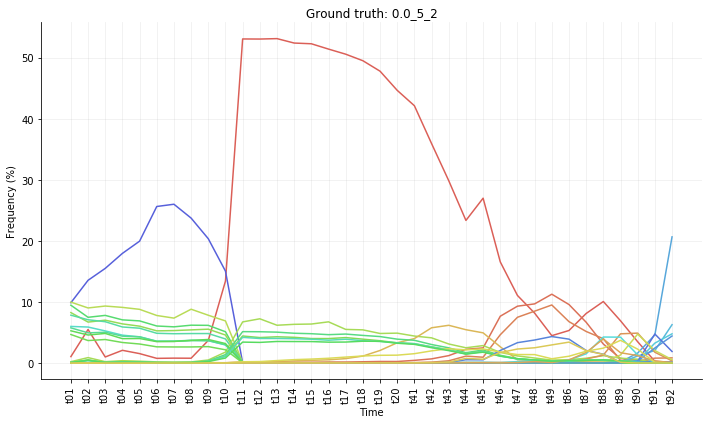

In [11]:
plot_trajectories(
    true_df, 
    out_fn = results_dir + f'_groundtruth_{true_df_name}.png',
    title = f'Ground truth: {true_df_name}',
    filter_fq = 0.04,
)

Plotting only gt trajectories: top 30. Trimming 75 ...
Trimmed to 30 gts.


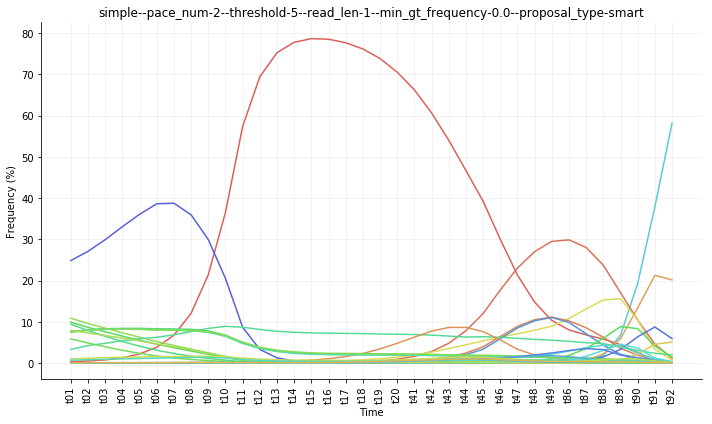

In [12]:
plot_trajectories(
    pred_df, 
    out_fn = results_dir + f'{dataset_nm}.png',
    title = f'{dataset_nm}',
    filter_fq = 0.01,
)

In [14]:
set(pred_df['Abbrev genotype'])

{'...........................',
 '..........................G',
 '..........................N',
 '.........................I.',
 '........................T..',
 '.......................K...',
 '......................Y....',
 '.....................D.....',
 '.....................H.....',
 '.....................S.....',
 '....................G......',
 '...................L.......',
 '..................H........',
 '.................N.........',
 '................N..........',
 '...............R...........',
 '...............R..........G',
 '...............R........T..',
 '...............R........T.G',
 '...............R......Y....',
 '...............R...L.......',
 '...............R...L......G',
 '...............RN..........',
 '...............RN.....Y....',
 '...............RN.....Y...G',
 '..............S............',
 '..............SRN.....Y....',
 '..............SRNNH..DY..IN',
 '..............T............',
 '..............TR...........',
 '..............TR......Y....',
 '......

In [18]:
import copy
dfs = copy.copy(pred_df)

dfs['max fq'] = dfs.apply('max', axis = 'columns')

wt_gt = '...........................'

In [19]:
dfs['max fq'].loc[wt_gt]

0.0015879379